In [1]:
import pandas as pd, numpy as np
import io
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
import matplotlib.pyplot as plt

# load the dataset
facts = pd.read_csv("deplen.tab",sep="\t")
facts = facts.sample(frac=1)



# Create a random 20% test set
train, test = train_test_split(facts, test_size=0.2, random_state=42)

# We have this many examples, stratified by number of children
print("Train, test sizes:")
print(train.shape, test.shape)

train.head()


Train, test sizes:
(3017, 10) (755, 10)


,edunum,position,chars,words,zwords,parentnum,dist,zdist,children,zchildren
2328,57,0.647727,72,16,6.409386,51,6,4.069652,1,-4.817135
3208,19,0.292308,47,11,1.340573,10,9,6.430899,2,1.000000
710,71,0.518248,23,6,-6.776290,69,2,-3.667675,1,-2.605539
3529,28,0.482759,19,4,-10.096427,10,18,12.989179,3,2.360706
3068,34,0.755556,52,11,-2.151597,11,23,29.141364,8,9.311930


In [2]:
train.describe()

,edunum,position,chars,words,zwords,parentnum,dist,zdist,children,zchildren
count,3017.000000,3017.000000,3017.000000,3017.00000,3017.000000,3017.000000,3017.000000,3017.000000,3017.000000,3017.000000
mean,38.540935,0.511837,73.476301,14.26881,0.908526,31.353331,6.910839,2.765571,2.131919,0.043580
std,26.031169,0.283428,53.685295,9.83513,8.732283,25.781636,14.727735,11.278315,2.139335,5.754816
min,1.000000,0.009615,3.000000,1.00000,-17.456606,0.000000,-57.000000,-30.669113,1.000000,-6.226753
25%,17.000000,0.268293,37.000000,8.00000,-5.045370,9.000000,1.000000,-2.745953,1.000000,-3.076105
50%,34.000000,0.511364,59.000000,12.00000,-1.074587,25.000000,2.000000,-0.997110,1.000000,-2.128333
75%,56.000000,0.756410,94.000000,18.00000,4.961177,48.000000,7.000000,3.883522,2.000000,0.487950
max,134.000000,1.000000,496.000000,98.00000,63.422984,130.000000,122.000000,82.288754,27.000000,64.156686


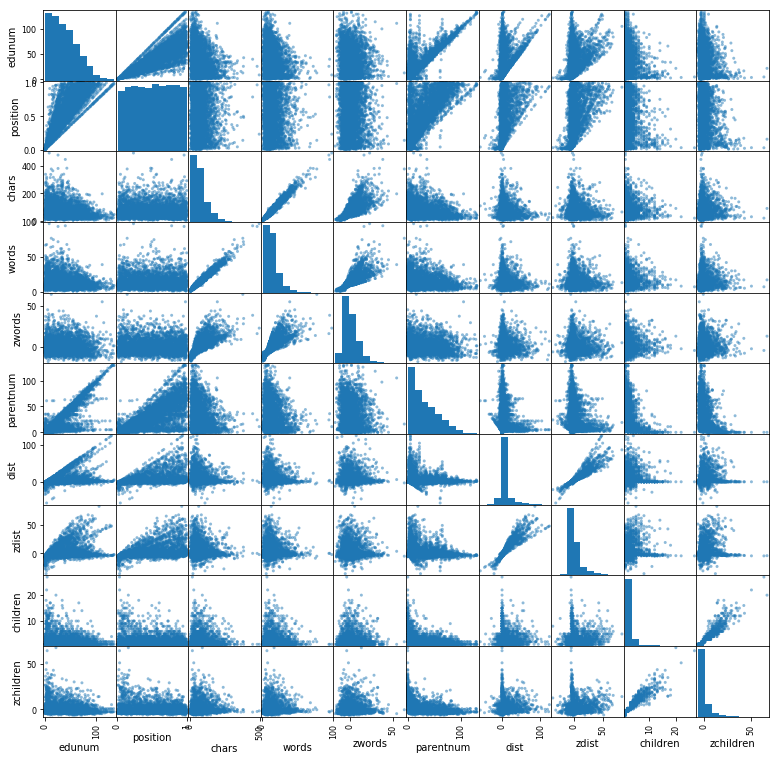

In [3]:
from pandas.plotting import scatter_matrix

scatter_matrix(facts,figsize=(13,13))
plt.show()

Text(0, 0.5, 'Distance to parent')

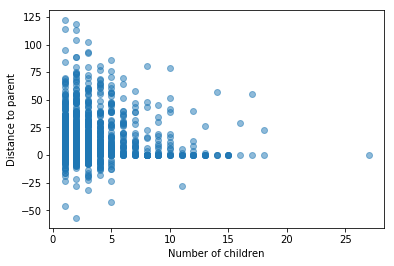

In [4]:
# Let's look at the relationship between number of children and how far the grandparent is

plt.scatter(train["children"],train["dist"],alpha=0.5)
plt.xlabel('Number of children')
plt.ylabel('Distance to parent')


In [5]:
# Let's try a naive linear model of number of children to parent distance
from sklearn.linear_model import SGDRegressor, LinearRegression
from sklearn.metrics import mean_squared_error

# Data is small so we can use LinearRegression
reg = LinearRegression()
# Reshape to make single feature column vector
# Switch to zdist
reg.fit(train["children"].values.reshape(-1,1),train["zdist"])

# Fit quality on train
preds = reg.predict(train["children"].values.reshape(-1,1))
fit_score = np.sqrt(mean_squared_error(train["zdist"],preds))
print("Score on train: " + str(fit_score))

# Score on test
preds = reg.predict(test["children"].values.reshape(-1,1))
pred_score = np.sqrt(mean_squared_error(test["zdist"],preds))
print("Score on test: "  + str(pred_score))

Score on train: 11.034792100583887
Score on test: 10.914804020691758


[1.08555505]


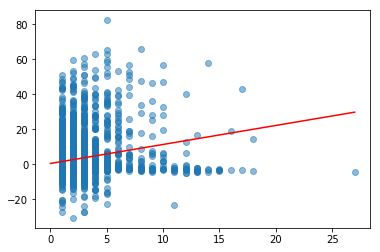

In [6]:
# What did the model learn?
print(reg.coef_)
plt.scatter(train["children"],train["zdist"],alpha=0.5)
newdata = np.array([[0],[27]])
pred = reg.predict(newdata)
plt.plot(newdata,pred, 'r-')
plt.show()

Score on train: 10.820279312539466
Score on test: 10.42348097435862


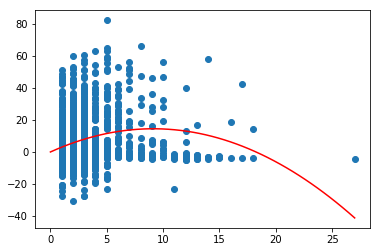

In [7]:
# Why not let the model use polynomial features?

from sklearn.preprocessing import PolynomialFeatures
poly_feats = PolynomialFeatures(degree=2)
X_poly = poly_feats.fit_transform(train["children"].values.reshape(-1,1))

reg.fit(X_poly,train["zdist"])

# Fit quality on train
preds = reg.predict(poly_feats.transform(train["children"].values.reshape(-1,1)))
fit_score = np.sqrt(mean_squared_error(train["zdist"],preds))
print("Score on train: " + str(fit_score))

# Score on test
preds = reg.predict(poly_feats.transform(test["children"].values.reshape(-1,1)))
pred_score = np.sqrt(mean_squared_error(test["zdist"],preds))
print("Score on test: "  + str(pred_score))


# Let's plot the polynomial that our model learned
plt.scatter(train["children"],train["zdist"])
x = np.linspace(0, 27)
y = np.array([np.sum(np.array([reg.coef_[i]*(j**i) for i in range(len(reg.coef_))])) for j in x])
plt.plot(x, y, 'r-')



Score on train: 10.752959017834167
Score on test: 10.301048455350793


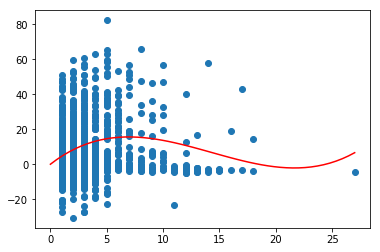

In [8]:
# How about degree 3?

poly_feats = PolynomialFeatures(degree=3)
X_poly = poly_feats.fit_transform(train["children"].values.reshape(-1,1))

reg.fit(X_poly,train["zdist"])

# Fit quality on train
preds = reg.predict(poly_feats.transform(train["children"].values.reshape(-1,1)))
fit_score = np.sqrt(mean_squared_error(train["zdist"],preds))
print("Score on train: " + str(fit_score))

# Score on test
preds = reg.predict(poly_feats.transform(test["children"].values.reshape(-1,1)))
pred_score = np.sqrt(mean_squared_error(test["zdist"],preds))
print("Score on test: "  + str(pred_score))


# Let's plot the polynomial that our model learned
plt.scatter(train["children"],train["zdist"])
x = np.linspace(0, 27)
y = np.array([np.sum(np.array([reg.coef_[i]*(j**i) for i in range(len(reg.coef_))])) for j in x])
plt.plot(x, y, 'r-')



Score on train: 10.829741844789378
Score on test: 1385.09271451285


(-70, 125)

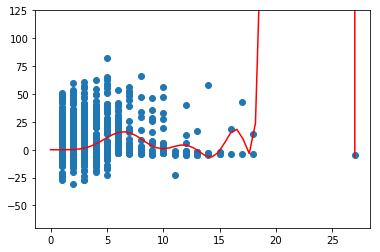

In [9]:
# When should we stop??

poly_feats = PolynomialFeatures(degree=14)
X_poly = poly_feats.fit_transform(train["children"].values.reshape(-1,1))

reg.fit(X_poly,train["zdist"])

# Fit quality on train
preds = reg.predict(poly_feats.transform(train["children"].values.reshape(-1,1)))
fit_score = np.sqrt(mean_squared_error(train["zdist"],preds))
print("Score on train: " + str(fit_score))

# Score on test
preds = reg.predict(poly_feats.transform(test["children"].values.reshape(-1,1)))
pred_score = np.sqrt(mean_squared_error(test["zdist"],preds))
print("Score on test: "  + str(pred_score))


# Let's plot the polynomial that our model learned
plt.scatter(train["children"],train["zdist"])
x = np.linspace(0, 27)
y = np.array([np.sum(np.array([reg.coef_[i]*(j**i) for i in range(len(reg.coef_))])) for j in x])
plt.plot(x, y, 'r-')
plt.ylim(-70,125)



In [10]:
# More features
feats = ["children","edunum","chars"]
reg.fit(train[feats].values,train["zdist"])

# Fit quality on train
preds = reg.predict(train[feats].values)
fit_score = np.sqrt(mean_squared_error(train["zdist"],preds))
print("Score on train: " + str(fit_score))

# Score on test
preds = reg.predict(test[feats].values)
pred_score = np.sqrt(mean_squared_error(test["zdist"],preds))
print("Score on test: "  + str(pred_score))

Score on train: 10.460798629983648
Score on test: 10.385186305036205


In [11]:
# Polynomial, now with interactions
feats = ["children","edunum","chars","words"]
poly_feats = PolynomialFeatures(degree=3)
X_poly = poly_feats.fit_transform(train[feats].values)

reg.fit(X_poly,train["zdist"])

# Fit quality on train
preds = reg.predict(X_poly)
fit_score = np.sqrt(mean_squared_error(train["zdist"],preds))
print("Score on train: " + str(fit_score))

X_test_poly = poly_feats.transform(test[feats].values)


# Score on test
preds = reg.predict(X_test_poly)
pred_score = np.sqrt(mean_squared_error(test["zdist"],preds))
print("Score on test: "  + str(pred_score))

Score on train: 9.309006034837708
Score on test: 8.433310839857779


## Assignment below

### 1. Baseline

Calculate the mean of all 'zdist'

In [13]:
y_pred_mean = sum(train['zdist']) / len(train)
baseline_score = np.sqrt(mean_squared_error(test["zdist"], [y_pred_mean]*len(test)))
print("Baseline score on test: "  + str(pred_score))

Baseline score on test: 8.433310839857779


## 2. Other features to reduce RMSE

In [29]:
# round feature position
train.round({'position':2, 'zwords':2, 'zchildren':2})
test.round({'position':2, 'zwords':2, 'zchildren':2})

feats_other = ['position', 'children', 'edunum', 'zwords', 'chars', 'parentnum']
X_poly_other = poly_feats.fit_transform(train[feats_other].values)

reg.fit(X_poly_other, train["zdist"])

X_test_poly = poly_feats.transform(test[feats_other].values)
# Score on test
preds_other = reg.predict(X_test_poly)
pred_score_other = np.sqrt(mean_squared_error(test["zdist"], preds_other))
print("Score on test: "  + str(pred_score_other))

Score on test: 3.4852139495616665


## 3. z or absolute?

In [26]:
# zwords
feats_zwords = ['position', 'edunum', 'zwords', 'chars']
reg.fit(train[feats_zwords].values,train["zdist"])
preds_zwords = reg.predict(test[feats_zwords].values)
pred_score_zwords = np.sqrt(mean_squared_error(test["zdist"], preds_zwords))
print("Score on test with zwords: "  + str(pred_score_zwords))

# abs words
feats_words = ['position', 'edunum', 'words', 'chars']
reg.fit(train[feats_words].values,train["zdist"])
preds_words = reg.predict(test[feats_words].values)
pred_score_words = np.sqrt(mean_squared_error(test["zdist"], preds_words))
print("Score on test with words: "  + str(pred_score_words))

# zchildren
feats_zchildren = ['position', 'edunum', 'zchildren', 'chars']
reg.fit(train[feats_zchildren].values,train["zdist"])
preds_zchildren = reg.predict(test[feats_zchildren].values)
pred_score_zchildren = np.sqrt(mean_squared_error(test["zdist"], preds_zchildren))
print("Score on test with zchildren: "  + str(pred_score_zchildren))

# abs children
feats_children = ['position', 'edunum', 'children', 'chars']
reg.fit(train[feats_children].values,train["zdist"])
preds_children = reg.predict(test[feats_children].values)
pred_score_children = np.sqrt(mean_squared_error(test["zdist"], preds_children))
print("Score on test with children: "  + str(pred_score_children))

Score on test with zwords: 10.744415083503691
Score on test with words: 10.750352744637006
Score on test with zchildren: 10.1780429752972
Score on test with children: 10.2588207463986


**zwords vs. words**: no big difference

**zchildren vs. children**: zchildren is better

## 4. zwords + words & zchildren + children

In [28]:
# zwords + words
feats_2words = ['position', 'edunum', 'zwords', 'words', 'chars']
reg.fit(train[feats_2words].values,train["zdist"])
preds_2words = reg.predict(test[feats_2words].values)
pred_score_2words = np.sqrt(mean_squared_error(test["zdist"], preds_2words))
print("Score on test with 2 words: "  + str(pred_score_2words))

# zchildren + children
feats_2children = ['position', 'edunum', 'children', 'chars']
reg.fit(train[feats_2children].values, train["zdist"])
preds_2children = reg.predict(test[feats_2children].values)
pred_score_2children = np.sqrt(mean_squared_error(test["zdist"], preds_2children))
print("Score on test with 2 children: "  + str(pred_score_2children))

Score on test with 2 words: 10.742274805056228
Score on test with 2 children: 10.2588207463986


Two representations with the same information do not reduce the loss on the test set compared with using one representation only.

## 5. Hyper-params: degree

In [52]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.metrics import make_scorer

def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree), LinearRegression(**kwargs))

def mse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

params = {'polynomialfeatures__degree': np.arange(1, 11)}

scoring = {'mse': make_scorer(mse, greater_is_better=False)}

grid = GridSearchCV(PolynomialRegression(), params, scoring=make_scorer(mse))
grid.fit(train[feats_other], train["zdist"])

grid.best_params_

C:\Users\zhuda\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\zhuda\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'polynomialfeatures__degree': 10}

The optimal polynomial degree on train is xx.

In [53]:
tuned_model = grid.best_estimator_
y_pred_train_tuned = tuned_model.fit(train[feats_other], train["zdist"]).predict(train[feats_other])
pred_score_train_tuned = mse(train["zdist"], y_pred_train_tuned)
print("Score on train with tuning: "  + str(pred_score_train_tuned))

Score on train with tuning: 2.5599941780522153


Obviously, on the training set, the higher the polinominal degree is, the lower the loss is. The optimal degree value on the training set is the number of data points. However, it will cause overfitting.

For the test set, a very high degree means the high similarity between the training and the test set. However, a very low degree also loses the variance of the model. In this case, an optimal degree value on the test set is low, but higher than a minimal threshold.

After rounding the three features 'position', 'zchildren', and 'zwords', I get a relatively low loss on the test set, which is **3.4852139495616665**.